In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from ukb_gwas import * # need to recopy back to scriptarchive, and re-link from here

# comparing betas from lists of SNPs

In [2]:
# make list of ALL snps of interest (all lead snps from gwas’s and from Lee et al)
lee_snps = [x.rstrip() for x in open('lee_eduyears_snps.txt','r').readlines()]
print(len(lee_snps))

1271


In [3]:
import glob
lead_snp_files = glob.glob('*_lead_*')
print(lead_snp_files)

['eduyears_wba_stayers_lead_snps.csv', 'eduyears_equalized_stayers_lead_snps.csv', 'eduyears_wba_movers_lead_snps.csv', 'eduyears_equalized_movers_lead_snps.csv']


In [4]:
lead_snps = {}
lead_snps['lee'] = lee_snps
for f in lead_snp_files:
    desc = f.split('_lead_')[0]
    snps = [x.split(',')[1] for x in open(f).readlines()[1:]]
    #print(f,len(snps))
    lead_snps[desc] = snps

In [5]:
for k in lead_snps.keys():
    print(k,len(lead_snps[k]))

lee 1271
eduyears_wba_stayers 138
eduyears_equalized_stayers 87
eduyears_wba_movers 250
eduyears_equalized_movers 129


In effect_size_comparisons.ipynb, I did this:
  * started with a list of snps
  * loaded betas and errors for 2 GWAS to compare
  * crunched numbers (errors, weighting, etc) and plotted  
  
So maybe that is what I should do here?

This code lifted from subsetting_EA_phenotype.ipynb

In [6]:
print('doing stayers')
# snpid=>beta, snpid=>error, snpid=>allele
sb,se,sa = get_betas_and_errors('eduyears_equalized_stayers') # ,'logistic')
print('done with stayers, doing movers')
mb,me,ma = get_betas_and_errors('eduyears_equalized_movers') # ,'logistic')
print('done with movers')

doing stayers
done with stayers, doing movers
done with movers


In [22]:
# filter snplist for those we have data for, and get betas and errors for these snps

snps_to_compare = lead_snps['eduyears_equalized_movers']

snplist = [x for x in snps_to_compare if x in sb.keys()]

snplist_betas_1 = []
snplist_betas_2 = []
snplist_errors_1 = []
snplist_errors_2 = []

# standardize checked alleles to stayers
for snp in snplist:
    
    snplist_betas_1.append(sb[snp])
    snplist_errors_1.append(se[snp])
    snplist_errors_2.append(me[snp])
    
    # are the scored alleles the same in stayers and movers?
    if sa[snp] != ma[snp]:
        print('allele switch for ' + snp + ', reversing mover beta')
        snplist_betas_2.append(-mb[snp])
    else:
        snplist_betas_2.append(mb[snp])
        
print(len(snplist_betas_1),len(snplist_errors_1))
print(len(snplist_betas_2),len(snplist_errors_2))

allele switch for rs2271961, reversing mover beta
129 129
129 129


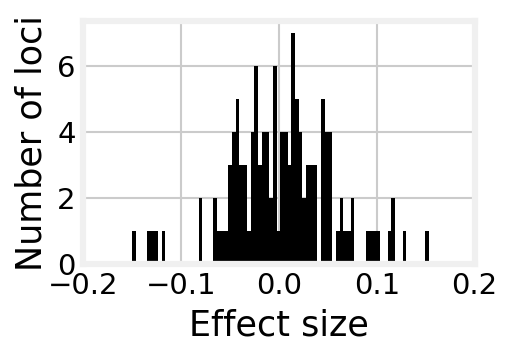

In [23]:
plt.style.use('fivethirtyeight')
f,a = plt.subplots(1,1,figsize=(3,2),dpi=150,facecolor='w')
a.set_facecolor('w')
a.hist(snplist_betas_1,100,color='k')
a.set_ylabel('Number of loci')
a.set_xlabel('Effect size')
a.set_xlim([-0.2,.2])
plt.show()

129 129


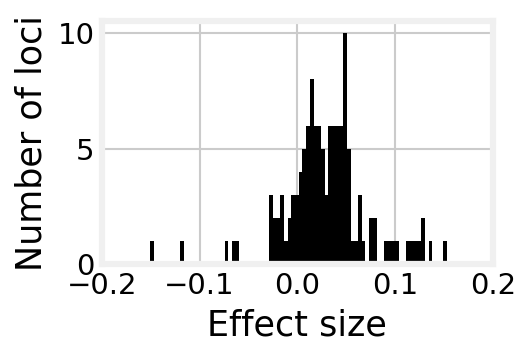

In [24]:
# magnitude ... do abs() unless signs opposite
# if sign switch .... make the larger one positive, and the smaller one negative

snplist_betas_1_magnitude = []
snplist_betas_2_magnitude = []

for i, sb1 in enumerate(snplist_betas_1):
    sb2 = snplist_betas_2[i]
    if (sb1 < 0 and sb2 < 0) or (sb1 >= 0 and sb2 >= 0):
        snplist_betas_1_magnitude.append(abs(sb1))
        snplist_betas_2_magnitude.append(abs(sb2))
        
    else: # if sign switch .... make the larger one positive, and the smaller one negative
        
        if abs(sb1) > abs(sb2):
            snplist_betas_1_magnitude.append(abs(sb1))
            snplist_betas_2_magnitude.append(-abs(sb2))
        else:
            snplist_betas_1_magnitude.append(-abs(sb1))
            snplist_betas_2_magnitude.append(abs(sb2))
print(len(snplist_betas_1_magnitude), len(snplist_betas_2_magnitude))

plt.style.use('fivethirtyeight')
f,a = plt.subplots(1,1,figsize=(3,2),dpi=150,facecolor='w')
a.set_facecolor('w')
a.hist(snplist_betas_1_magnitude,100,color='k')
a.set_ylabel('Number of loci')
a.set_xlabel('Effect size')
a.set_xlim([-0.2,.2])
plt.show()

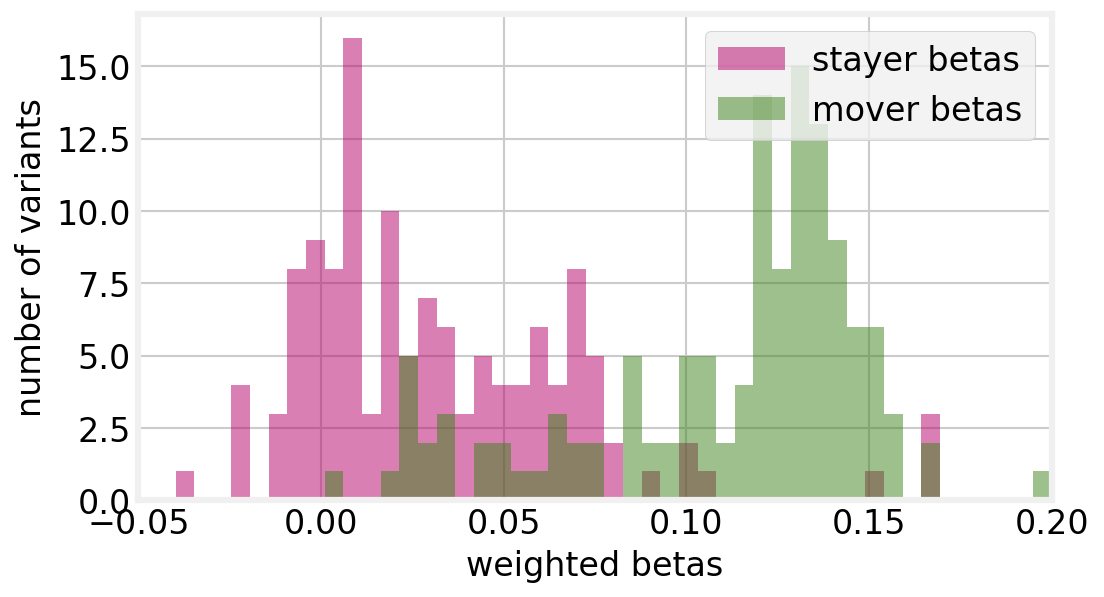

In [25]:
# let's look at those betas!

numBins = 50
plt.style.use('fivethirtyeight')
b1 = snplist_betas_1_magnitude
b2 = snplist_betas_2_magnitude

bins = np.linspace(-0.05, 0.2, numBins)

#f,(a1,a2) = plt.subplots(1,2,figsize = (14,4))
f,a2 = plt.subplots(1,1,figsize = (7,4),facecolor='w',dpi=150)

# a1.hist(b1,bins,alpha = 0.5, label='stayers unrelated-5', color = 'blue')
# a1.hist(b2,bins,alpha = 0.5, label='movers unrelated-5', color = 'green')
# a1.legend(loc='upper right', fontsize=16)
# a1.set_ylabel('number of variants')
# #plt.yscale('log')
# a1.set_xlabel('betas')
#plt.suptitle('Eduyears: 1252 Lee snps, 40 PCs UKB')

cls = [[0.705,0,0.411],[0.24,0.51,0.1]]
#cls = ['tab:blue','tab:green']
#cls = ['c','y'] # female male

j1,j2,wb1 = get_weighted_avg_beta(b1,snplist_errors_1)
j1,j2,wb2 = get_weighted_avg_beta(b2,snplist_errors_2)
a2.hist(wb1,bins,alpha = 0.5, label='stayer betas', color = cls[0])
a2.hist(wb2,bins,alpha = 0.5, label='mover betas', color = cls[1])
a2.set_xlabel('weighted betas',fontsize=16)
a2.set_ylabel('number of variants',fontsize=16)
a2.legend(loc='upper right', fontsize=16)
a2.tick_params(axis='both', which='major', labelsize=16)
a2.set_facecolor('w')
a2.set_xlim([-0.05,0.2])
plt.show()

In [26]:
zstat, eff1, eff2 = calc_z_statistic(b1,b2,
                         snplist_errors_1,snplist_errors_2,'stayers','movers')
p_values = stats.norm.sf(abs(zstat))*2
print('pval: ','{:1.1e}'.format(p_values))
print()
print('movers more: ', '{:1.1f}%'.format((eff2-eff1) * 100 / eff1))

stayers:  avg_eff 0.0327  variance: 4.725e-06
movers:  avg_eff 0.1127  variance: 4.611e-06

difference in effect:  -0.0800

z-statistic:  -26.1838
pval:  4.1e-151

movers more:  244.8%


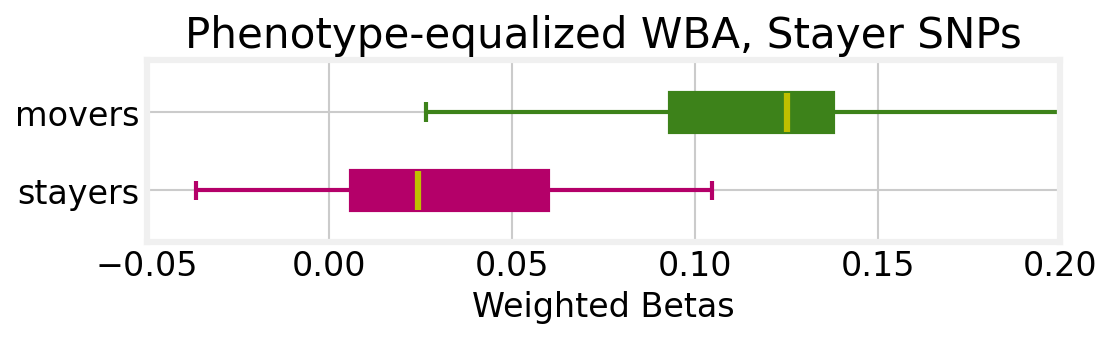

In [27]:
f,a = plt.subplots(1,1,figsize=(7,1.5),dpi=150,facecolor='w')
bp = plt.boxplot(wb1, positions=[1], patch_artist=True, showfliers = False, vert = False)
for element in ['boxes', 'whiskers', 'fliers', 'means', 'caps']:
    plt.setp(bp[element], color=cls[0] , linewidth = 2)
plt.setp(bp['medians'], color = 'y', linewidth = 3)

bp = plt.boxplot(wb2, positions=[1.3], patch_artist=True, showfliers = False, vert = False)
for element in ['boxes', 'whiskers', 'fliers', 'means', 'caps']:
    plt.setp(bp[element], color=cls[1], linewidth = 2)
plt.setp(bp['medians'], color = 'y', linewidth = 3)


plt.yticks([1,1.3],['stayers','movers'])
plt.ylim([0.8,1.5])

a.tick_params(axis='both', which='major', labelsize=16)
a.set_facecolor('w')
a.set_xlim([-0.05,0.2])
plt.xlabel('Weighted Betas',fontsize=16)

plt.title('Phenotype-equalized WBA, Mover SNPs')

plt.show()

# equalized EA phenotypes

much of this code lifted from effect_size_comparisons.ipynb
June 6 2021: add code to partition lists randomly, e.g. to divide into 2 groups

In [5]:
eduyears = pd.read_csv('../pheno/pheno_eduYears.csv',delimiter = ' ')
print(len(eduyears))
eduyears.head(2)

492398


,eid,eid.1,val
0,3609487,3609487,20
1,1194904,1194904,20


In [14]:
with open('equalized_wba_movers.csv','r') as f:
    equalized_wba_movers = [int(x.split()[0]) for x in f.readlines()]
with open('equalized_wba_stayers.csv','r') as f:
    equalized_wba_stayers = [int(x.split()[0]) for x in f.readlines()]
    
with open('wba_stayers.csv','r') as f:
    wba_stayers = [int(x.split()[0]) for x in f.readlines()]
with open('wba_movers.csv','r') as f:
    wba_movers = [int(x.split()[0]) for x in f.readlines()]

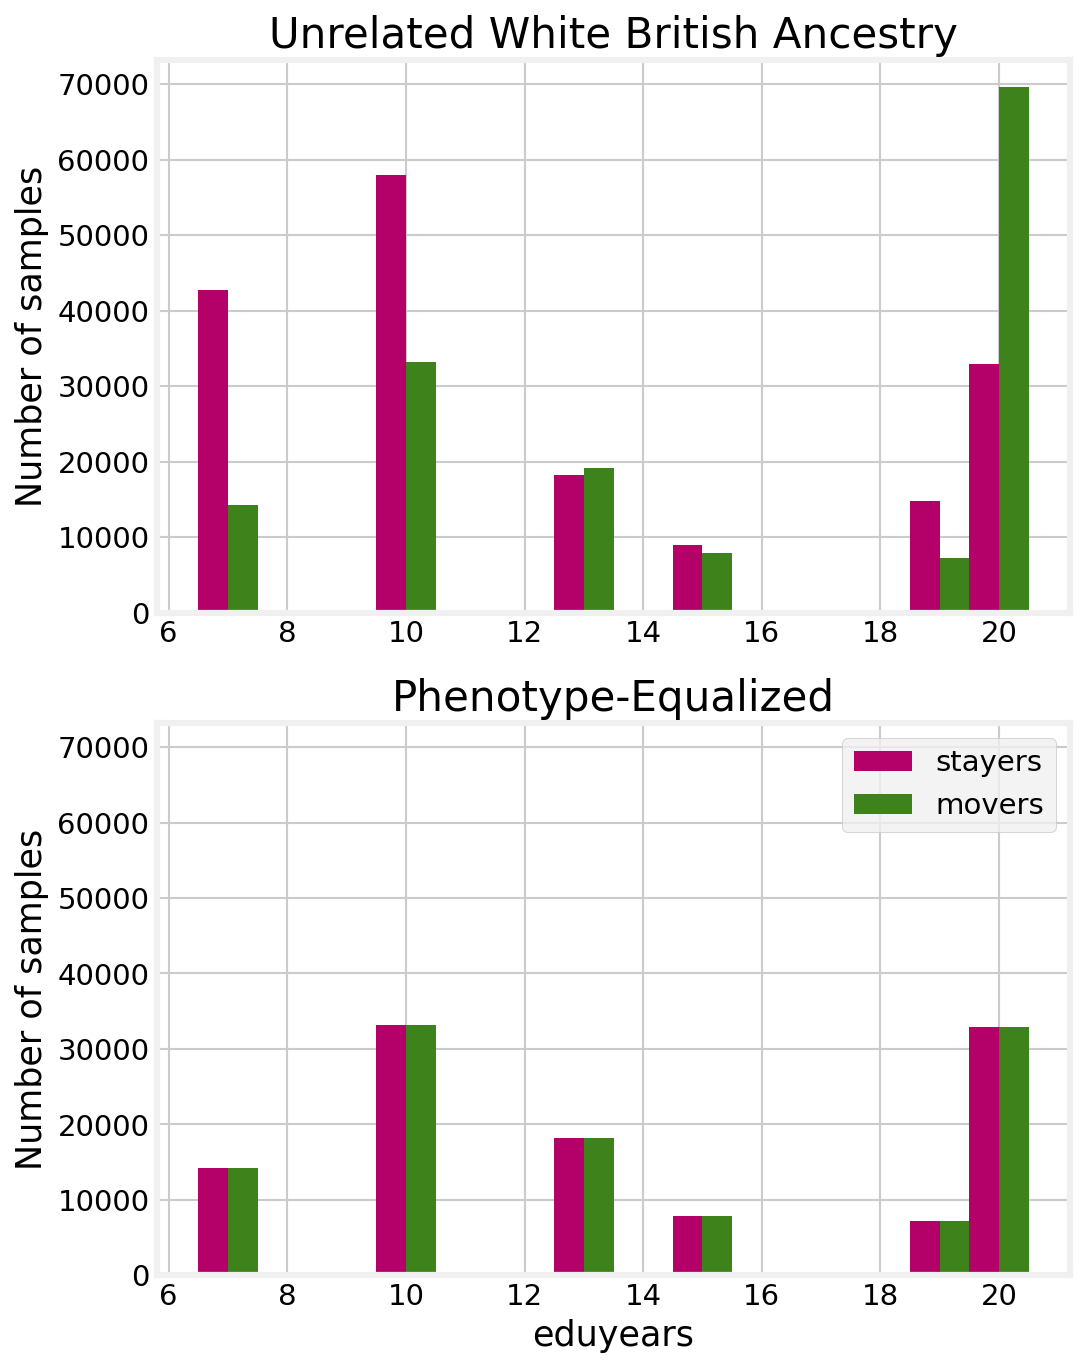

In [7]:
plt.style.use('fivethirtyeight')
f,(a1,a2) = plt.subplots(2,1,figsize=(7,10), facecolor = 'w', sharey = True, dpi=150)

#cls = ['tab:blue','tab:green']
cls = [[0.705,0,0.411],[0.24,0.51,0.1]]

edvals = np.unique(eduyears.val.tolist())
moverList = wba_movers
stayerList = wba_stayers

for edval in edvals:
    eids_for_edval = eduyears[eduyears.val==edval].eid.tolist()
    
    num_stayers = len(list(set(eids_for_edval)&set(stayerList)))
    a1.bar(edval - 0.25, num_stayers, width = 0.5, color = cls[0])
    
    num_movers = len(list(set(eids_for_edval)&set(moverList)))   
    a1.bar(edval+0.25, num_movers, width = 0.5, color = cls[1])

a1.set_title('Unrelated White British Ancestry')
#a1.set_xlabel('eduyears')
a1.set_ylabel('Number of samples')
a1.set_facecolor('w')


edvals = np.unique(eduyears.val.tolist())
moverList = equalized_wba_movers
stayerList = equalized_wba_stayers

for edval in edvals:
    eids_for_edval = eduyears[eduyears.val==edval].eid.tolist()
    
    num_stayers = len(list(set(eids_for_edval)&set(stayerList)))
    a2.bar(edval - 0.25, num_stayers, width = 0.5, color = cls[0])
    
    num_movers = len(list(set(eids_for_edval)&set(moverList)))   
    a2.bar(edval+0.25, num_movers, width = 0.5, color = cls[1])

a2.bar(edval - 0.25, num_stayers, width = 0.5, color = cls[0], label = 'stayers')
a2.bar(edval+0.25, num_movers, width = 0.5, color = cls[1], label = 'movers')
a2.legend()

a2.set_title('Phenotype-Equalized')
a2.set_xlabel('eduyears')
a2.set_ylabel('Number of samples')
a2.set_facecolor('w')
plt.show()

In [8]:
print('wba_stayers:           ',len(wba_stayers))
print('wba_movers:            ',len(wba_movers))
print('equalized_wba_stayers: ',len(equalized_wba_stayers))
print('equalized_wba_movers:  ',len(equalized_wba_movers))

wba_stayers:            177519
wba_movers:             152227
equalized_wba_stayers:  113550
equalized_wba_movers:   113550


In [49]:
# No good to just divide randomly shuffled groups evenly ... 
# instead, need to divide groups within each EA category!

# first, find # in each group within each EA category ... from eduyears dataframe
edvals = np.unique(eduyears.val.tolist())
print(edvals)

moverList = list(equalized_wba_movers)
stayerList = list(equalized_wba_stayers)

movers_a = []
movers_b = []
stayers_a = []
stayers_b = []

# go through each value in edvals and find eids in each group with that edval
# then shuffle and subdivide

for edval in edvals:
    print('edval = ', edval)
    
    # find eids with this edval from each group
    eids_with_edval = list(eduyears[eduyears.val == edval].eid.values)
    movers_with_edval = list(set(eids_with_edval) & set(moverList) )
    stayers_with_edval = list(set(eids_with_edval) & set(stayerList) )    
    
    # convert lists to arrays, and shuffle
    shuffled_movers_with_edval = np.array(movers_with_edval)
    shuffled_stayers_with_edval = np.array(stayers_with_edval)    
    
    np.random.shuffle(np.array(shuffled_movers_with_edval))
    np.random.shuffle(np.array(shuffled_stayers_with_edval))
    
    # grab what we need from shuffled arrays
    numToGet = int(len(movers_with_edval) / 2)
    movers_to_add_a = shuffled_movers_with_edval[:numToGet]
    movers_to_add_b = shuffled_movers_with_edval[numToGet:]
    
    stayers_to_add_a = shuffled_stayers_with_edval[:numToGet]
    stayers_to_add_b = shuffled_stayers_with_edval[numToGet:]
    
    if len(movers_to_add_b) > len(movers_to_add_a):
        movers_to_add_b = movers_to_add_b[:-1]
        stayers_to_add_b = stayers_to_add_b[:-1]
    
    print(len(movers_to_add_a), len(movers_to_add_b),len(stayers_to_add_a), len(stayers_to_add_b))
    
    # add these to overall lists
    movers_a.extend(list(movers_to_add_a))
    movers_b.extend(list(movers_to_add_b))
    
    stayers_a.extend(list(stayers_to_add_a))
    stayers_b.extend(list(stayers_to_add_b))
    
print(movers_a[:5], len(movers_a))
print(movers_b[:5], len(movers_b))
print(stayers_a[:5], len(stayers_a))
print(stayers_b[:5], len(stayers_b))

[ 7 10 13 15 19 20]
edval =  7
7110 7110 7110 7110
edval =  10
16588 16588 16588 16588
edval =  13
9094 9094 9094 9094
edval =  15
3936 3936 3936 3936
edval =  19
3604 3604 3604 3604
edval =  20
16442 16442 16442 16442
[3375105, 1179659, 5111820, 1507343, 5767184] 56774
[3915985, 1753298, 4604115, 4767956, 1196245] 56774
[1277952, 5013505, 2981890, 2392074, 5832715] 56774
[1654845, 1327174, 3391560, 3981386, 2965579] 56774


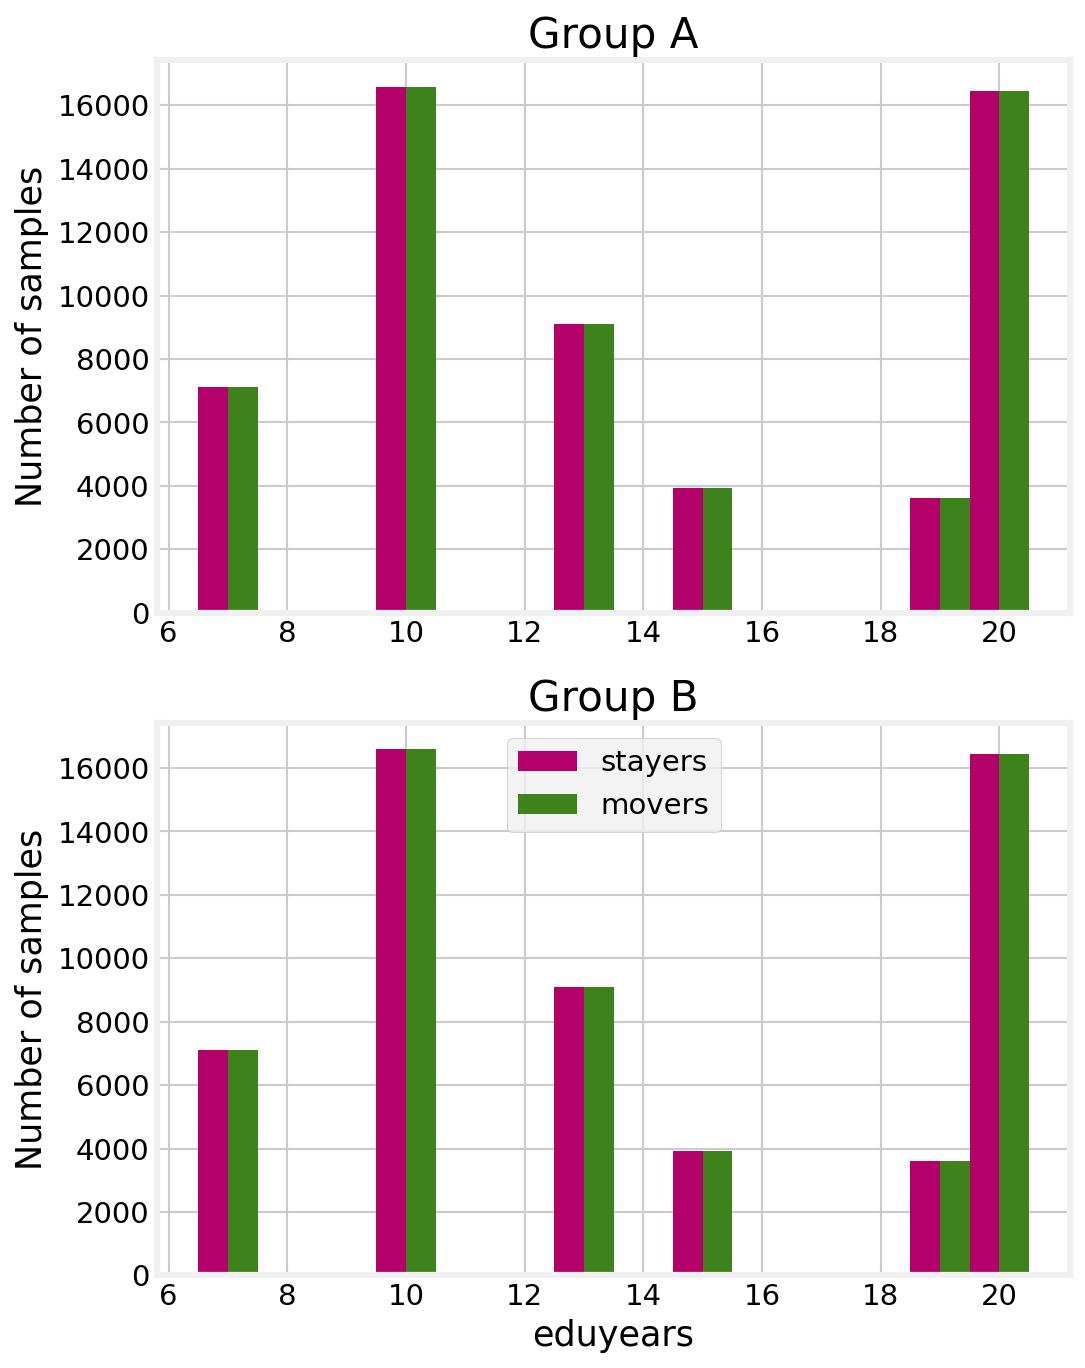

In [50]:
# see how they look
plt.style.use('fivethirtyeight')
f,(a1,a2) = plt.subplots(2,1,figsize=(7,10), facecolor = 'w', sharey = True, dpi=150)

#cls = ['tab:blue','tab:green']
cls = [[0.705,0,0.411],[0.24,0.51,0.1]]

edvals = np.unique(eduyears.val.tolist())
moverList = movers_a
stayerList = stayers_a

for edval in edvals:
    eids_for_edval = eduyears[eduyears.val==edval].eid.tolist()
    
    num_stayers = len(list(set(eids_for_edval)&set(stayerList)))
    a1.bar(edval - 0.25, num_stayers, width = 0.5, color = cls[0])
    
    num_movers = len(list(set(eids_for_edval)&set(moverList)))   
    a1.bar(edval+0.25, num_movers, width = 0.5, color = cls[1])

a1.set_title('Group A')
#a1.set_xlabel('eduyears')
a1.set_ylabel('Number of samples')
a1.set_facecolor('w')

moverList = movers_b
stayerList = stayers_b

for edval in edvals:
    eids_for_edval = eduyears[eduyears.val==edval].eid.tolist()
    
    num_stayers = len(list(set(eids_for_edval)&set(stayerList)))
    a2.bar(edval - 0.25, num_stayers, width = 0.5, color = cls[0])
    
    num_movers = len(list(set(eids_for_edval)&set(moverList)))   
    a2.bar(edval+0.25, num_movers, width = 0.5, color = cls[1])

a2.bar(edval - 0.25, num_stayers, width = 0.5, color = cls[0], label = 'stayers')
a2.bar(edval+0.25, num_movers, width = 0.5, color = cls[1], label = 'movers')
a2.legend()

a2.set_title('Group B')
a2.set_xlabel('eduyears')
a2.set_ylabel('Number of samples')
a2.set_facecolor('w')
plt.show()

In [55]:
# save files
eid_list = stayers_a
fname = 'stayers_a.csv'
o = open(fname,'w')
for eid in eid_list:
    s = str(eid)
    o.write(s + ' ' + s + '\n')
o.close()